<h1>Where To Open A Bubble Tea Shop</h1>

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem  <a name="introduction"></a>

I love bubble tea. Enough that I've thought about opening my own bubble tea shop. There are a few in my area, but there are definitely large gaps in coverage for service of this delicacy. If I were to open a bubble tea shop in the Vancouver (Washington) area, where would the best place be to open it?

## Data <a name="data"></a>

For general venue information, I used foursquare. It provides excellent location based data on what venues are in areas and where they are.

Unfortunately bubble tea shops in the area do not seem to perfectly match up with Foursquare’s data. So to get more accurate shop information, I had to use my own knowledge of the area as well as web listings to check all possible shops. Many of the venues listed were either no longer in business or didn’t offer bubble tea, but by the end of checking search results and venue listings, I was fairly confident I had found all the real and currently in business bubble tea shops in the area. Coordinate data for these locations was gathered from google maps.

Additionally, I found zip code area data from inspecting the following link’s source code: [Vancouver, Washington (WA) ZIP Code Maps, Data, Jobs](https://washington.hometownlocator.com/zip-codes/zipcodes,city,vancouver.cfm)

**The Vancouver Area**

In [3]:
import pandas as pd
from geopy.geocoders import Nominatim
import geopy.distance
#!conda install -c conda-forge folium
import folium

import json
import requests

In [4]:
#geolocator = Nominatim(user_agent="nw_explorer")
#location = geolocator.geocode("Vancouver, Washington")
latitude = 45.6506954 #45.6306954 up > down
longitude = -122.6344557 #-122.6744557 right > left

def centroid(vertexes):
    _x_list = [vertex [0] for vertex in vertexes]
    _y_list = [vertex [1] for vertex in vertexes]
    _len = len(vertexes)
    _x = sum(_x_list) / _len
    _y = sum(_y_list) / _len
    return (_x, _y)

with open('data/vancouver.json') as json_data:
    vancouver_json = json.load(json_data)

vancouver_data = []
for d in vancouver_json["features"]:
    vancouver_data.append({
        "DISTRICT": d["properties"]["DISTRICT"],
        "NUM":      d["properties"]["OBJECTID"],
        "location": centroid(d["geometry"]["coordinates"][0])
    })

df_vancouver = pd.DataFrame({
    "Zip Code":  [d["DISTRICT"]    for d in vancouver_data],
    "NUM":       [d["NUM"]         for d in vancouver_data],
    "Latitude":  [d["location"][1] for d in vancouver_data],
    "Longitude": [d["location"][0] for d in vancouver_data]
})

# calculate average distance between points
distances = []
for lng1, lat1 in [d["location"] for d in vancouver_data]:
    for lng2, lat2 in [d["location"] for d in vancouver_data]:
        distances.append(geopy.distance.distance((lat1, lng1), (lat2, lng2)).m)

avg_distance = sum(distances) / len(distances)

df_vancouver

,Zip Code,NUM,Latitude,Longitude
0,98660,1,45.675670,-122.712327
1,98661,2,45.643017,-122.631724
2,98662,3,45.680128,-122.579466
3,98663,4,45.649467,-122.661825
4,98664,5,45.625573,-122.579907
5,98665,6,45.679095,-122.678850
6,98682,1,45.670014,-122.490251
7,98683,2,45.607477,-122.509805
8,98684,3,45.629745,-122.517547
9,98685,4,45.714627,-122.702391


I was able to find some geojson data for vancouver area codes, enough to make a map of them and figure out about the center of those area codes for the sake of querying foursquare.

In [137]:
vancouver_map = folium.Map(location=[latitude, longitude], zoom_start=11)
choropleth = folium.Choropleth(
    geo_data="data/vancouver.json",
    data=df_vancouver, # my dataset
    columns=['Zip Code', 'NUM'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
    key_on='feature.properties.DISTRICT', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Vancouver Washington By Zip Code'
)
choropleth.add_to(vancouver_map)
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['DISTRICT'],labels=False)
)

# add markers to map
for lat, lng, zip_code in zip(df_vancouver['Latitude'], df_vancouver['Longitude'], df_vancouver['Zip Code']):
    label = '{}'.format(zip_code)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(vancouver_map)

vancouver_map

There's some issues here, the areas aren't uniform, and some of the centers aren't even contained in the area they go to. I don't have a good way of improving this without a lot of work, so I'll leave it as is for now.

**Foursquare Venue Data**

In [101]:
# Foursquare API credentials, not included for security reasons
with open("data/credentials.json") as json_file:
    credentials = json.load(json_file)

CLIENT_ID = credentials['CLIENT_ID']
CLIENT_SECRET = credentials['CLIENT_SECRET']
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # Foursquare API limit value

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
    
def getNearbyVenues(names, latitudes, longitudes, radius=avg_distance/2):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, # meters
            LIMIT
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Zip Code Latitude', 
                  'Zip Code Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

vancouver_venues = getNearbyVenues(
    names=df_vancouver['Zip Code'],
    latitudes=df_vancouver['Latitude'],
    longitudes=df_vancouver['Longitude']
)
vancouver_venues.drop_duplicates(inplace=True)
vancouver_venues.head()

,Zip Code,Zip Code Latitude,Zip Code Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,98660,45.67567,-122.712327,Vancouver Lake Park,4bcb52b568f976b0aad46083,45.678094,-122.742696,Park
1,98660,45.67567,-122.712327,Grapes ‘n Growlers,59e68be916fa044e98fa89dc,45.698477,-122.703509,Restaurant
2,98660,45.67567,-122.712327,Black Rock Coffee Bar,5130e06de4b0ed892aef661b,45.678360,-122.667440,Coffee Shop
3,98660,45.67567,-122.712327,Killer Burger,5a7399fa8e886a73e97057fe,45.681325,-122.665444,Burger Joint
4,98660,45.67567,-122.712327,Don Pedro's,4be2114cf07b0f470ea5f443,45.669224,-122.663471,Burrito Place


Now that we have the Foursquare venue data, let's look at some of it.

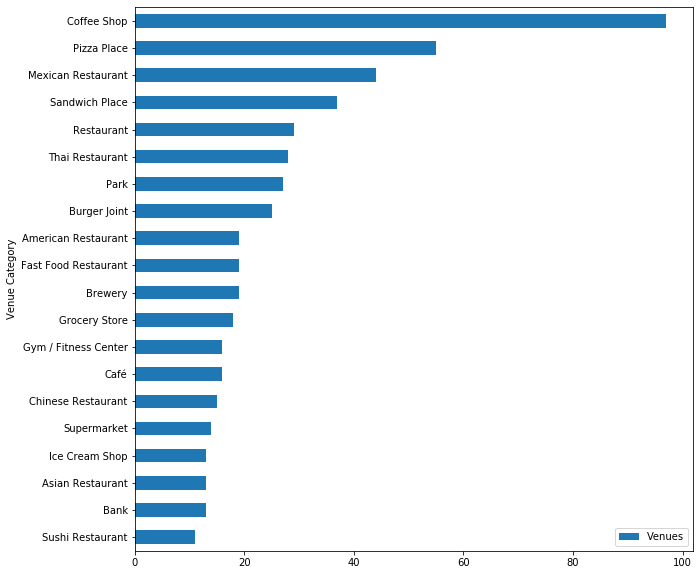

In [102]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

vancouver_venue_count = vancouver_venues.drop(
    ['Zip Code', 'Zip Code Latitude', 'Zip Code Longitude', 'Venue', 'Venue ID', 'Venue Latitude', 'Venue Longitude'], axis=1
)
vancouver_venue_count['Venues'] = 1
vancouver_venue_count = vancouver_venue_count.groupby(['Venue Category'], axis=0).sum()
vancouver_venue_count.sort_values(by='Venues', inplace=True)

vancouver_venue_count.tail(20).plot.barh(figsize=(10, 10))


This shows that the most common venues in the area are *Coffee shops*, as well as the rest of the top 20 most common venues in the area.

Next, lets take a look at the places in the area that serve bubble tea, and see if they're in our data set.

**Bubble Tea Venues**

In [61]:
def searchQueryToDF(near, query, limit=100):
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&query={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        near,
        query,
        limit
    )

    # make the GET request
    results = requests.get(url).json()["response"]['venues']

    venue_list = []
    
    for v in results:
        v_name  = v['name']
        v_id    = v['id']
        v_lat   = v['location']['lat']
        v_lng   = v['location']['lng']
        v_state = v['location'].get('state', '')  
        v_city  = v['location'].get('city', '')
        v_cat   = ''
        
        if len(v.get('categories', [])) > 0:
            v_cat = v['categories'][0].get('name', '')
        
        venue_list.append([
            (v_name, v_id, v_lat, v_lng, v_state, v_city, v_cat)
        ])
            
    venues = pd.DataFrame([item for vl in venue_list for item in vl])
    venues.columns = [
        'Venue', 
        'Venue ID',
        'Latitude', 
        'Longitude',
        'State',
        'City', 
        'Category'
    ]
    
    return venues

In [57]:
bubble_tea_venues = searchQueryToDF("Vancouver, WA", "bubble tea")

# filter out results from neighboring state of Oregon
bubble_tea_venues[bubble_tea_venues['State'] == 'WA']

,Venue,Venue ID,Latitude,Longitude,State,City,Category
1,Boba Bubble Tea,5b8a01caa4ba7c002c1b1077,45.641514,-122.617195,WA,Vancouver,True
5,Vibe Coffee & Bubble Tea,4f4fc76d7b0c748bb66eb409,45.689316,-122.659264,WA,Vancouver,True
9,Northwest Bubble Tea Supl,4f328eba19836c91c7e37866,45.704192,-122.540406,WA,Vancouver,True
14,Carnelian Rose Tea Co,4f327fd419836c91c7ddc8bb,45.635151,-122.670868,WA,Vancouver,True
15,Peet's Coffee & Tea,5227b1b08bfdf21a788fc270,45.631979,-122.668533,WA,Vancouver,True
16,Tea Bar Downtown,4f7ccc35e4b02c414345e87a,45.629280,-122.671249,WA,Vancouver,True
17,The Enchanted Gift Shop & Tea Room,4c6858477963be9ae042cdbc,45.624979,-122.672832,WA,Vancouver,True
18,Revive Espresso & Tea (Andresen Rd.),4c706757d7fab1f790885ec9,45.642576,-122.600536,WA,Vancouver,True
19,Blue Gables Tea House,4f32b2bc19836c91c7f0f478,45.680717,-122.617725,WA,Vancouver,True
20,Revive Espresso & Tea (Hazel Dell),4f54edb1e4b0639bbc06eaac,45.693205,-122.664789,WA,Vancouver,True


Most of these results are for places that don't actually offer bubble tea. And some of the places aren't even open any more. Fortunately, I've been able to make a list of the bubble tea shops in the area. Let's map those out.

In [63]:
bubble_tea_shops = [
    "Braganza Tea", "Boba Tree", "Bobablastic", "Sharetea", "Boba Factory", "Cupidone Coffee House"
]

df_bts_list = []
for bts in bubble_tea_shops:
    df_bts_list.append(searchQueryToDF("Vancouver, WA", bts, 2))

df_bts = pd.concat(df_bts_list)

# filter out results from neighboring state of Oregon
df_bts[df_bts['State'] == 'WA']

,Venue,Venue ID,Latitude,Longitude,State,City,Category
1,Braganza - Pearl Teas,4b661f14f964a520d7142be3,45.657905,-122.584000,WA,Vancouver,Bubble Tea Shop
0,Leo'z Tree Service,55268868498e3d5db2a90f34,45.639563,-122.662783,WA,Vancouver,Tree
1,Boba Bubble Tea,5b8a01caa4ba7c002c1b1077,45.641514,-122.617195,WA,Vancouver,Bubble Tea Shop
0,Bobablastic,54ce8f55498e42f1c3db134d,45.678125,-122.660455,WA,Hazel Dell,Bubble Tea Shop
0,Boba Bubble Tea,5b8a01caa4ba7c002c1b1077,45.641514,-122.617195,WA,Vancouver,Bubble Tea Shop
1,Dishwasher Factory,57712461498e98ab94fe1fb8,45.639927,-122.668699,WA,Vancouver,Business Center
0,Cupidone Coffee House,52e7e1d811d2456c20999c37,45.644391,-122.598953,WA,Vancouver,Café
1,Main St. Coffee House,4beb1d46b3352d7f170e56d2,45.625854,-122.671341,WA,Vancouver,Coffee Shop


hmm, that doesn't seem to work either... So instead I've researched the locations myself and added them below.

In [73]:
bubble_tea_places = [{
    "Venue": "Braganza Tea",
    "Address": "8700 NE Vancouver Mall Dr, Vancouver, WA 98662",
    "Latitude": 45.6585741,
    "Longitude": -122.581517
}, {
    "Venue": "Boba Tree",
    "Address": "5210 NE Fourth Plain Blvd B, Vancouver, WA 98661",
    "Latitude": 45.6414567,
    "Longitude": -122.6171505
}, {
    "Venue": "Bobablastic",
    "Address": "1015 Pacific Hwy & NE 78th st, Vancouver, WA 98665",
    "Latitude": 45.6783072,
    "Longitude": -122.6606374
}, {
    "Venue": "Bobablastic",
    "Address": "2201 Main St, Vancouver, WA 98660",
    "Latitude": 45.6379345,
    "Longitude": -122.6710547
}, {
    "Venue": "Sharetea",
    "Address": "7902 NE 6th Ave, Vancouver, WA 98665",
    "Latitude": 45.6796943,
    "Longitude": -122.6673761
}, {
    "Venue": "Sharetea",
    "Address": "19206 SE 1st St Unit 114, Camas, WA 98607",
    "Latitude": 45.6216139,
    "Longitude": -122.4749915
}, {
    "Venue": "Boba Factory",
    "Address": "8605 NE Hwy 99 #110, Vancouver, WA 98665",
    "Latitude": 45.6848604,
    "Longitude": -122.6599414
}, {
    "Venue": "Cupidone Coffee House",
    "Address": "3021 NE 72nd Dr #11, Vancouver, WA 98661",
    "Latitude": 45.644269,
    "Longitude": -122.5989661
}]

df_bubble_tea_places = pd.DataFrame({
    "Venue":     [p["Venue"]     for p in bubble_tea_places],
    "Address":   [p["Address"]   for p in bubble_tea_places],
    "Latitude":  [p["Latitude"]  for p in bubble_tea_places],
    "Longitude": [p["Longitude"] for p in bubble_tea_places]
})

bubble_tea_map = folium.Map(location=[latitude, longitude], zoom_start=11)
choropleth.add_to(bubble_tea_map)

# add markers to map
for lat, lng, venue in zip(df_bubble_tea_places['Latitude'], df_bubble_tea_places['Longitude'], df_bubble_tea_places['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(bubble_tea_map)

bubble_tea_map

So, what next? Well, we have an optimization problem of finding a location close to lots of venues while not being close to the competition.

**Finding the best location**

In [131]:
# make a grid of points within the confines of Vancouver
## First, we need to simplify the bounderies of Vancouver to something we can roughly aproximate.
## I'll choose to represent vancouver as a rectangle with a triangle along the bottom and fill it with points.
# rect = 45.654 to 45.731, -122.752 to -122.476
# tri = [(45.654, -122.752), (45.654, -122.476), (45.584, -122.476)]

grid = []
lat_range_1 = 45.731 - 45.654
lat_range_2 = 45.654 - 45.584
lng_range   = 122.752 - 122.476
lat_min_1   = 45.654
lat_min_2   = 45.584
lng_min     = -122.752

def calculatePoint(lat, lng):
    point = {
        'Latitude':  lat,
        'Longitude': lng,
        'score': 0,
        'color': '#888888'
    }
    venue_weight  = 100 / vancouver_venues.shape[0]
    bubble_weight = 100 / df_bubble_tea_places.shape[0]
    
    # calculate score by proximity to venues and bubble tea shops
    # calculation based on gravity equation G*M*m/r^2
    
    for vlat, vlng in zip(vancouver_venues['Venue Latitude'], vancouver_venues['Venue Longitude']):
        r = geopy.distance.distance((lat, lng), (vlat, vlng)).m
        point['score'] += venue_weight / (r * r)
        
    for blat, blng in zip(df_bubble_tea_places['Latitude'], df_bubble_tea_places['Longitude']):
        r = geopy.distance.distance((lat, lng), (blat, blng)).m
        point['score'] -= bubble_weight / (r * r)
        
    grid.append(point)

for i in range(0, 21):
    lng = lng_min + lng_range * (i/20)
    for j in range(0, 11):
        lat = lat_min_1 + lat_range_1 * (j/10)
        calculatePoint(lat, lng)
    for j in range(0, int(i/2)):
        lat = lat_min_2 + lat_range_2 - (lat_range_2 * (j/10))
        calculatePoint(lat, lng)

# get range of scores
max_score = 0
min_score = 0
max_point = grid[0]
for point in grid:
    if point['score'] > max_score:
        max_score = point['score']
        max_point = point
    if point['score'] < min_score:
        min_score = point['score']

In [132]:
# assign color based on score
for point in grid:
    if point['score'] > 0:
        if point['score'] / max_score >= (1/10):
            point['color'] = '#ff0000'
        elif point['score'] / max_score >= (1/100):
            point['color'] = '#cc8888'
    if point['score'] < 0:
        if point['score'] / min_score >= (1/10):
            point['color'] = '#0000ff'
        elif point['score'] / min_score >= (1/100):
            point['color'] = '#8888cc'

grid_map = folium.Map(location=[latitude, longitude], zoom_start=11)
#choropleth.add_to(grid_map)
# display venues as black dots
for vlat, vlng, name in zip(vancouver_venues['Venue Latitude'], vancouver_venues['Venue Longitude'], vancouver_venues['Venue']):
        folium.CircleMarker(
            [vlat, vlng],
            radius=1,
            color='#000000',
            popup=name,
            fill=True,
            fill_color='#000000',
            fill_opacity=0.3
        ).add_to(grid_map)
            
# display grid of points, colored to indicate positive/negative value (blue/gray/red?)
for point in grid:
    if point['Latitude'] == max_point['Latitude'] and point['Longitude'] == max_point['Longitude']:
        folium.CircleMarker(
            [point['Latitude'], point['Longitude']],
            radius=6,
            popup='Highest score: {}'.format(point['score']),
            color=point['color'],
            fill=True,
            fill_color=point['color'],
            fill_opacity=0.7
        ).add_to(grid_map)
    else:
        folium.CircleMarker(
            [point['Latitude'], point['Longitude']],
            radius=2,
            popup=point['score'],
            color=point['color'],
            fill=True,
            fill_color=point['color'],
            fill_opacity=0.7
        ).add_to(grid_map)
        
grid_map

In [136]:
max_point

{'Latitude': 45.605000000000004,
 'Longitude': -122.5036,
 'score': 0.000278895645791412,
 'color': '#ff0000'}

## Methodology  <a name="methodology"></a>

To get an idea for the area I was working with, I used the zip code coordinate data to calculate the center of each zip code area, and used python’s folium library to display the city and its zip codes. I was further able to use this data to calculate a rough area to search for venues in.

From there, I went on to get foursquare venue data. I queried it for venues nearby the center of each zip code to get fairly good coverage of the region, and converted the query results into a Pandas DataFrame containing the following venue information: Zip Code, Venue, Venue ID, Venue Latitude, Venue Longitude, and Venue Category.

I explored the data to see what venues were common in the area, and checked for bubble tea venue information. As mentioned in the data section, there were some issues with the accuracy of the information on bubble tea venues, probably partly because it returned a lot of tea and coffee shops that didn’t sell bubble tea, and partly because some of the venue information was outdated due to shops closing. So I eventually had to gather the data myself as best I could through search engines, google maps, and personal knowledge of the area.

With this information, I started on trying to solve the original question of where would be the ideal location for another bubble tea shop. I created a grid of points that were to be scored on quality of location, positively correlated with proximity to other venues, and negatively correlated with proximity to existing bubble tea shops. This in my estimation should find a location that was both good for business, and lacking in competition from other bubble tea venues.


## Results <a name="results"></a>

After tweaking the logic and number of points some to refine the display and make the calculations complete in under an hour (distance calculations between hundreds of venues for each point in a grid with several thousand points was a little too ambitious), I was able to make a map detailing the rough suitability of locations, along with highlighting the location with the highest score. That location ended up being in the area of Southeast 164th Avenue and Southeast McGrillivray Boulevard.

## Discussion <a name="discussion"></a>

Some of the locations that scored well surprised me, but the logic seems to check out. I think part of it is I’m not used to thinking in terms of venue distribution. In my head, I was prioritizing distance from other bubble tea shops. Being far away from competition though is in no way a guarantee of success though, and if that was the only criteria then the ideal location for a new venue would be in the middle of nowhere. Obviously though, any shop that doesn’t have many potential customers in its area is going to fail. So I used a calculation that would allow venue density to tell me indirectly where there would be many potential customers.

These results might be further improved with a deeper understanding of who potential customers for bubble tea would be, crossed with census information for the area. It may be that proximity to high schools or other types of locations is more advantageous for bubble tea shops then for other venues.

## Conclusion <a name="conclusion"></a>

I think this is a solid recommendation for where to look to open a bubble tea shop. And the methods used here, venue data on the competition and venues in the area in general used to generate a weighted grid of an area, could be useful in finding possible locations for other types of venues in other cities as well.